In [332]:
## import lib
import pandas as pd
import numpy as np
from numpy.linalg import pinv,inv,matrix_power
from scipy.linalg import sqrtm
from scipy.io import loadmat
import itertools
import math
import csv
import matplotlib.pyplot as plt

In [116]:
def Turn2OneHot(feature):
    Orientation_onehot = np.zeros(4)
    GAD_onehot = np.zeros(6)
    Orientation = int(feature[5])-2 # range: 2,3,4,5 -> eg. 3 == [0100]; 4 == [0010]
    GAD = int(feature[7]) # range: 0,1,2,3,4,5 -> eg. 2 == [001000]; 4 == [000010]
    Orientation_onehot[Orientation] = 1
    GAD_onehot[GAD] = 1
    Orientation_onehot = Orientation_onehot.tolist()
    GAD_onehot = GAD_onehot.tolist()
    feature = feature[:5] + Orientation_onehot + [feature[6]] + GAD_onehot
    return feature
    

# load data
categorical2onehot_index = [5, 7]
data_dir = './Dataset/energy_efficiency_data.csv'
df_data = pd.read_csv(data_dir,header=None)
Data_N, attr_N = df_data.shape

# create feature
All_onehot_feat = []
print('Total-data-Num : ',Data_N)
for i in range(Data_N):
    if i > 0:
        feat = list(map(float, df_data.iloc[[i]].as_matrix()[0]))
        onehot_feat = Turn2OneHot(feat)
        All_onehot_feat.append(onehot_feat)
tr_feat = np.array(All_onehot_feat[:576])
ts_feat = np.array(All_onehot_feat[576:])
tr_label = list(map(float, df_data[8][1:577].as_matrix()))
ts_label = list(map(float, df_data[8][577:].as_matrix()))

feat_dim = tr_feat.shape[1]
print('len of tr_feat = ',len(tr_feat))
print('len of ts_feat = ',len(ts_feat))
print('len of tr_label = ',len(tr_label))
print('len of ts_label = ',len(ts_label))
print('type of tr_feat = ',type(tr_feat))
print('type of ts_feat = ',type(ts_feat))
print('type of tr_label = ',type(tr_label))
print('type of ts_label = ',type(ts_label))

Total-data-Num :  769
len of tr_feat =  576
len of ts_feat =  192
len of tr_label =  576
len of ts_label =  192
type of tr_feat =  <class 'numpy.ndarray'>
type of ts_feat =  <class 'numpy.ndarray'>
type of tr_label =  <class 'list'>
type of ts_label =  <class 'list'>


[ 0.34285761 -0.06326756  0.23798109  0.27209001 -0.85453632  0.90532712
  0.25464195  0.33813283  0.77940197  0.81422631]
[ 0.07947554  0.48274148 -0.33470527  0.10438787 -1.03659158 -2.03458309
 -0.97326653 -1.73415396 -0.36436368 -0.49531736]
[0.77222142]
8.569245222430139


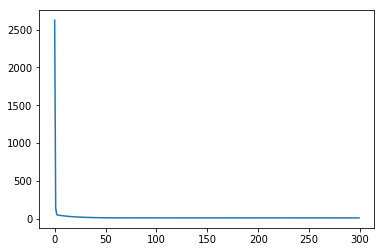

In [329]:
# Initial-Para.
W1 = np.random.randn(feat_dim, 10)
W2 = np.random.randn(10, 10)
W3 = np.random.randn(10, 1)
b1 = np.random.randn(10)
b2 = np.random.randn(10)
b3 = np.random.randn(1)
lr = 1e-9

def act_func(a_ary):
    # RELU
    a_ary[a_ary<0]=0
    return a_ary

def act_derivative(a_ary):
    # Derivative of RELU
    a_ary[a_ary<=0]=0
    a_ary[a_ary>0]=1
    return a_ary
    
# fwd, bwd
def fwd(input_X):
    b1_mat = np.tile(b1,(576,1)).T
    b2_mat = np.tile(b2,(576,1)).T
    b3_mat = np.tile(b3,(576,1)).T    
    a1 = np.matmul(W1.T,input_X.T) + b1_mat
    h1 = act_func(a1)
    a2 = np.matmul(W2.T,h1) + b2_mat
    h2 = act_func(a2)
    a3 = np.matmul(W3.T,h2) + b3_mat
    y_pre = a3
    return a1, a2, a3, h1, h2, y_pre
    
def bwd(x,h1,h2,y_pred,a1,a2,a3,yt_label):
    global b1,b2,b3,W1,W2,W3
    
    g = -2*(yt_label-y_pred)
    
    # third-layer
    grad_b3 = np.sum(g,axis = 1)
    grad_w3 = np.matmul(g,h2.T).T
    g = np.matmul(W3,g)
    
    # second-layer
#     g = np.multiply(g, act_derivative(a2))
    g = (a2>0)*g
#     
    grad_b2 = np.sum(g,axis = 1)
    grad_w2 = np.matmul(g,h1.T).T
    g = np.matmul(W2,g)
    
    # first-layer
#     g = np.multiply(g, act_derivative(a1))
    g = (a1>0)*g
    
    grad_b1 = np.sum(g,axis = 1)
    grad_w1 = np.matmul(g,x).T
    
    grad_b = [grad_b1,grad_b2,grad_b3]
    grad_w = [grad_w1,grad_w2,grad_w3]
    return grad_b, grad_w

def Check_para():
    print(b1)
    print(b2)
    print(b3)
#     print(W1)
#     print(W2)
#     print(W3)
    
    
# main-function
Check_para()
rms_err_lst = []
for i in range(300):
    a1, a2, a3, h1, h2, y_pred = fwd(tr_feat)
    grad_b, grad_w = bwd(tr_feat, h1, h2, y_pred, a1, a2, a3, tr_label)
#     rms_err = np.sqrt( np.sum((y_pred - tr_label)**2) / 576 )
    rms_err = np.sqrt( np.mean((y_pred - tr_label)**2))

    b1 -= lr*grad_b[0]
    b2 -= lr*grad_b[1]
    b3 -= lr*grad_b[2]
    W1 -= lr*grad_w[0]
    W2 -= lr*grad_w[1]
    W3 -= lr*grad_w[2]
    rms_err_lst.append(rms_err)
#     print(rms_err)

print(rms_err)
plot(range(300), rms_err_lst)  


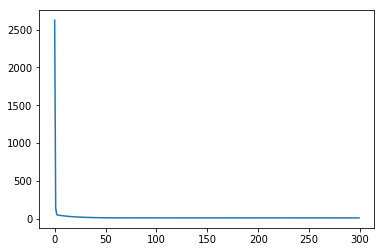

In [342]:
plt.plot(range(300), rms_err_lst)  
plt.savefig('Training_curve.png')

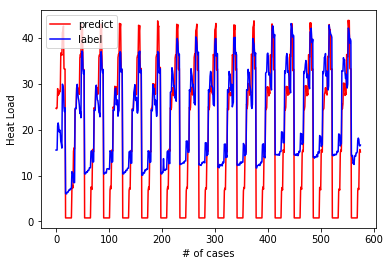

In [337]:
training_plot, = plt.plot(range(576),y_pred.T,'r',label="predict")
testing_plot, = plt.plot(range(576),np.array(tr_label),'b',label="label")
plt.legend(handles=[training_plot,testing_plot])
plt.xlabel('# of cases')
plt.ylabel('Heat Load')
plt.savefig('Training_problem1.png')
plt.show()
# savefig('')

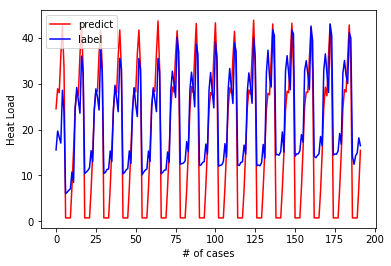

In [341]:
# start testing

b1_mat_test = np.tile(b1,(192,1)).T
b2_mat_test = np.tile(b2,(192,1)).T
b3_mat_test = np.tile(b3,(192,1)).T    
a1_test = np.matmul(W1.T,ts_feat.T) + b1_mat_test
h1_test = act_func(a1_test)
a2_test = np.matmul(W2.T,h1_test) + b2_mat_test
h2_test = act_func(a2_test)
a3_test = np.matmul(W3.T,h2_test) + b3_mat_test
y_pre = a3_test

training_plot, = plt.plot(range(192),y_pre.T,'r',label="predict")
testing_plot, = plt.plot(range(192),np.array(ts_label),'b',label="label")
plt.legend(handles=[training_plot,testing_plot])
plt.xlabel('# of cases')
plt.ylabel('Heat Load')
plt.savefig('Testing_problem1.png')
plt.show()